# Snazzy Mixing

## Preliminaries
The goal of this toolkit is to provide proper mixing and upsampling ratios for datasets that have been partitioned along multiple axes.

Some assumptions to begin:
- We have a dataset that is partitioned along both quality and topic. For example, we have data that belongs to a `(quality, topic)` bucket, as in `(decile_7, medicine)` indicating the 7th decile in terms of quality, amongst medical documents. We know how many tokens are in each one of these buckets.
- We require that the output dataset have a pre-specified number of tokens from each topic bucket.
- We require an output dataset with a pre-specified amount of tokens.
- We don't want to upsample any document more than 7 times (7 is a hyperparameter that has been experimentally identified).
- We are okay throwing away all low-quality documents.
- We want to upsample higher-quality documents more than lower-quality documents.

## Some notation:
- Let $X$ be the number of tokens in the input dataset. This is broken into buckets of `(quality, topic)`, subscripted like $X_{q,t}$. Topics can be thought of as unordered, but the quality partition is _strictly ordered_.
- The space of quality buckets is $\mathcal{Q}$, and the space of topics is $\mathcal{T}$. 
- Let $p^*$ be the desired ratio of each topic in the output dataset, as determined by our topic-mixing procedure (RegMix).
- Let $Z$ be the desired number of tokens in the output dataset, again broken into buckets of `(quality, topic)`, like $Z_{q,t}$.
- Let $Y_{q,t}$ be the up/downsampling ratio for each $(q,t)$ bucket. That is, $\forall (q,t)\; Z_{q,t} = Y_{q,t}\cdot X_{q,t}$
- Let $M$ be the maximum upsampling ratio (defaults to 7), i.e. $Y_{q,t} \leq M$.

Note, where convenient, we will shorthand sums across topics or quality buckets by omitting their subscript, e.g. $Z_t := \sum_{q} Z_{q,t}$.

Then this basically becomes an optimization procedure, where we seek values $Y_{q,t}$, that meet the following constraints:
- **(Attain the right token yield):** $\sum_{q,t} Z_{q,t} = Z$
- **(Respect topic mixing ratios):** $p^*_t = Z_{t}/Z$
- **(Don't upsample too much):** For all $t,q$, $f_t(q) \leq M$

## Approach:
We use the following key insight: can consider each topic separately, and for each topic $t$, we generate $Y_{t,q}$ based on outputs from a parametric curve. We make a modeling choice to select a family of curves that meet the following criteria:
- They are strongly convex and monotonic
- They are defined on the interval $[0, 1]$ (we can normalize these later)
- We can control the total integral: $\int_{0}^1 f(x)dx = Z_t / X_t$
- We can control the maximum integral of the right-most bucket: $\int_{1-b}^{1} f(x)dx \leq M$
- We can truncate the lower buckets to be zero: $\int_0^a f(x)dx = 0$

We settle on using a truncated Power-Exponential function:
$$  f_{p, \lambda}(x) = 
  \begin{cases}
    0, & \text{for } x < a \\
    C(x-a)^p\cdot e^{\lambda(x-a)}, & \text{for } x \geq a\\
  \end{cases}
$$

Specifically, this is an feasibility problem for each topic like:
Find parameters $p, \lambda$ such that:
- $\int_0^1 f_{p, \lambda} f_{p, \lambda}(x)dx = Z_t / X_t$
- $\int_{1-b}^1 f_{p, \lambda}(x)dx \leq M$
- $\lambda >= 0$
  
Where $M$ is a hyperparameter for the max allowable upsampling rate, taken to be 7. The constant $b$ is the the proportion of the data for any given topic in the highest-quality bucket, i.e.: $b := \max_t X_{q,t} / X_q$, and the constant $a$ is the proportion of data that lives in buckets that we want to throw away. I.e., if we want to throw away the bottom half of the data, $a \approx \frac{1}{2}$. In practice, we accumulate the low-quality buckets until we're just below half of the data. 

Once we find an acceptable $f_{p, \lambda}$, we map from the continuous function to the discrete binnings by taking the average value of the function over the interval spanned by the bucket. 

(All these tools are offloaded in a separate python file, which we import, for cleanliness of this file)

# Simple Example

In [1]:
import mixing_utils as mu

In [2]:
""" Example usage:
Mixing config.json should look like:
{
  pool: [[quality, topic, #tokens, s3_path (optional)], ...,  <-- original token counts
  target_tokens: int(100e9),
  pstar: {topic1: 0.01, topic2: 0.42, ...} <-- results from topic-mixing
  max_upsample: 7, <-- maximum number of 
  throwaway: 0.5, <-- (roughly) what fraction of the data should be thrown away [sampled 0 times]
}


"""

EXAMPLE_CONFIG = {
    'pool': [[0, 'medicine', 1000], [1, 'medicine', 2000], [0,  'science', 3000], [1, 'science', 4000]],
    'target_tokens': 20_000,
    'pstar': {'medicine': 0.3, 'science': 0.7},
    'max_upsample': 7,
    'throwaway': 0.5
}

In [3]:
# And then we can load/parse the config, and process each topic to get curves/upsample ratios
PROCESS_EXAMPLE_CONFIG = mu.process_config_dict(EXAMPLE_CONFIG)
OUTPUT_INFO = mu.process_all(PROCESS_EXAMPLE_CONFIG)


Topics:   0%|          | 0/2 [00:00<?, ?it/s]

{'p': 2.0, 'lambda': 0.19999999403953553, 'C': 18.316896325718783, 'tail_average': 2.9999999999999996, 'actual_integral': 2.0, 'feasible': True, 'constraint_satisfied': True, 'integral_error': 0.0, 'method_used': 'constraint_based'}


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Upsampling curve: medicine'}, xlabel='Data quality', ylabel='Upsampling'>)

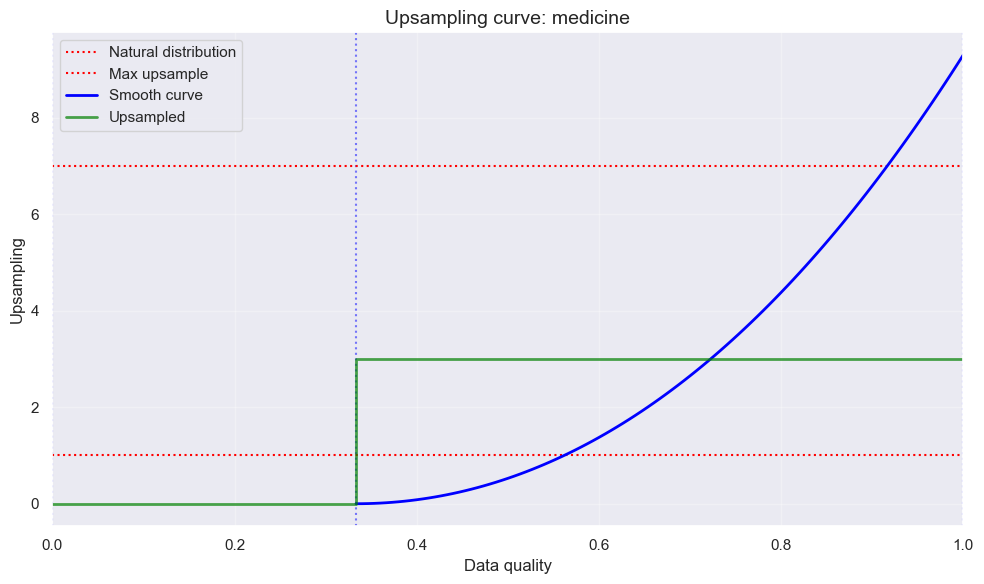

In [9]:
# And we can examine the curves like:
import seaborn as sns
sns.set()
mu.plot_curves(OUTPUT_INFO, 'medicine')

{'p': 2.0, 'lambda': 0.19999999403953553, 'C': 29.50763979083335, 'tail_average': 3.5, 'actual_integral': 1.9999999999999998, 'feasible': True, 'constraint_satisfied': True, 'integral_error': 2.220446049250313e-16, 'method_used': 'constraint_based'}


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Upsampling curve: science'}, xlabel='Data quality', ylabel='Upsampling'>)

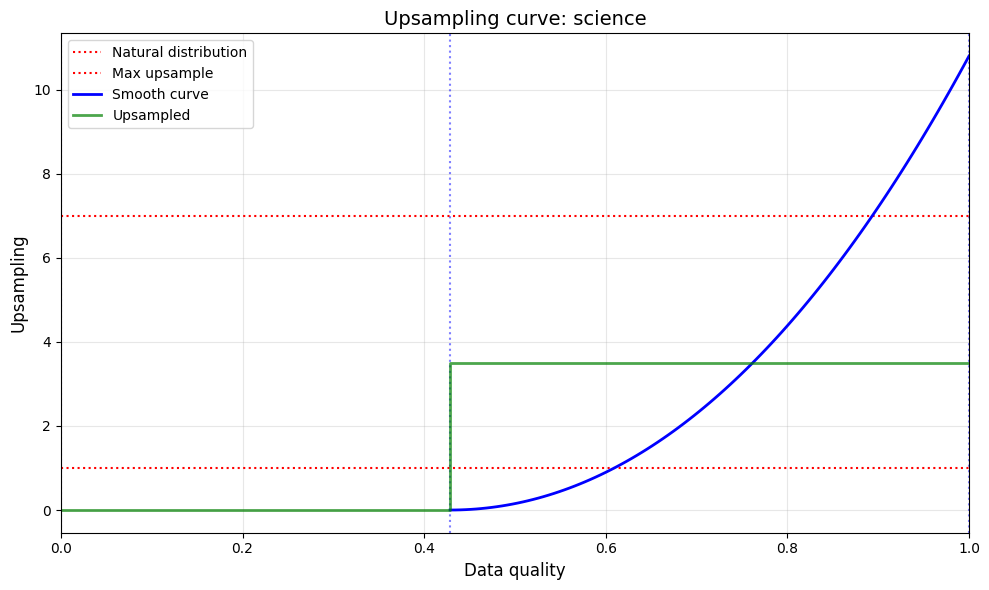

In [5]:
mu.plot_curves(OUTPUT_INFO, 'science')

In [6]:
mu.verify_output(OUTPUT_INFO)

Checking topics...
	Topic medicine passed checks
	Topic science passed checks
All topics passed checks!


# Real Example

In [7]:
REAL_EXAMPLE_PSTAR = {'adult_content': 0.001144117810399051, 'art_and_design': 0.01249707367344882, 'crime_and_law': 0.02923482987563418, 'education_and_jobs': 0.042876790729263314, 'electronics_and_hardware': 0.03452411494012139, 'entertainment': 0.09598475243055875, 'fashion_and_beauty': 0.00012733666316416182, 'finance_and_business': 0.04067027113145341, 'food_and_dining': 0.014086159108083668, 'games': 0.06891284699600658, 'health': 0.09942183338931967, 'history_and_geography': 0.027098556464741227, 'home_and_hobbies': 0.009226467887549798, 'industrial': 0.015745768366251897, 'literature': 0.0682512927464629, 'politics': 0.02170366281584968, 'religion': 0.019765203386769094, 'science_math_and_technology': 0.2102541083699082, 'social_life': 0.00464628155954837, 'software': 0.04733898713026143, 'software_development': 0.11142142430705981, 'sports_and_fitness': 0.013072140601763493, 'transportation': 0.009798609444870071, 'travel_and_tourism': 0.002197370171511048}
N_tv = {('adult_content', 'vigintile_0007'): 280726625, ('adult_content', 'vigintile_0008'): 102457504, ('adult_content', 'vigintile_0009'): 134182564, ('adult_content', 'vigintile_0010'): 176864303, ('adult_content', 'vigintile_0011'): 161999374, ('adult_content', 'vigintile_0012'): 172295290, ('adult_content', 'vigintile_0013'): 192984372, ('adult_content', 'vigintile_0014'): 210335716, ('adult_content', 'vigintile_0015'): 246496030, ('adult_content', 'vigintile_0016'): 307949833, ('adult_content', 'vigintile_0017'): 353261284, ('adult_content', 'vigintile_0018'): 293301804, ('adult_content', 'vigintile_0020'): 16468675, ('art_and_design', 'vigintile_0005'): 771917660, ('art_and_design', 'vigintile_0006'): 201422854, ('art_and_design', 'vigintile_0007'): 197454257, ('art_and_design', 'vigintile_0008'): 212616251, ('art_and_design', 'vigintile_0009'): 231886120, ('art_and_design', 'vigintile_0010'): 256543055, ('art_and_design', 'vigintile_0011'): 284066415, ('art_and_design', 'vigintile_0012'): 313091941, ('art_and_design', 'vigintile_0013'): 348310411, ('art_and_design', 'vigintile_0014'): 394742702, ('art_and_design', 'vigintile_0015'): 429501499, ('art_and_design', 'vigintile_0016'): 471165557, ('art_and_design', 'vigintile_0017'): 513038952, ('art_and_design', 'vigintile_0018'): 559809823, ('art_and_design', 'vigintile_0020'): 417408293, ('crime_and_law', 'vigintile_0002'): 437111165, ('crime_and_law', 'vigintile_0003'): 220563015, ('crime_and_law', 'vigintile_0004'): 237123764, ('crime_and_law', 'vigintile_0005'): 258110539, ('crime_and_law', 'vigintile_0006'): 280520071, ('crime_and_law', 'vigintile_0007'): 303017751, ('crime_and_law', 'vigintile_0008'): 322384457, ('crime_and_law', 'vigintile_0009'): 348562561, ('crime_and_law', 'vigintile_0010'): 377904531, ('crime_and_law', 'vigintile_0011'): 405493021, ('crime_and_law', 'vigintile_0012'): 440359527, ('crime_and_law', 'vigintile_0013'): 478045345, ('crime_and_law', 'vigintile_0014'): 516638173, ('crime_and_law', 'vigintile_0015'): 562375037, ('crime_and_law', 'vigintile_0016'): 620080765, ('crime_and_law', 'vigintile_0017'): 672090636, ('crime_and_law', 'vigintile_0018'): 712893526, ('crime_and_law', 'vigintile_0020'): 583786205, ('education_and_jobs', 'vigintile_0003'): 1124118523, ('education_and_jobs', 'vigintile_0004'): 477430746, ('education_and_jobs', 'vigintile_0005'): 491638257, ('education_and_jobs', 'vigintile_0006'): 512385187, ('education_and_jobs', 'vigintile_0007'): 535533399, ('education_and_jobs', 'vigintile_0008'): 559375798, ('education_and_jobs', 'vigintile_0009'): 598211642, ('education_and_jobs', 'vigintile_0010'): 642169933, ('education_and_jobs', 'vigintile_0011'): 691628886, ('education_and_jobs', 'vigintile_0012'): 746650934, ('education_and_jobs', 'vigintile_0013'): 818250219, ('education_and_jobs', 'vigintile_0014'): 886807187, ('education_and_jobs', 'vigintile_0015'): 970852150, ('education_and_jobs', 'vigintile_0016'): 1021894290, ('education_and_jobs', 'vigintile_0017'): 1052476631, ('education_and_jobs', 'vigintile_0018'): 1072998087, ('education_and_jobs', 'vigintile_0020'): 881950323, ('electronics_and_hardware', 'vigintile_0005'): 1047732910, ('electronics_and_hardware', 'vigintile_0006'): 250616866, ('electronics_and_hardware', 'vigintile_0007'): 273940100, ('electronics_and_hardware', 'vigintile_0008'): 290897666, ('electronics_and_hardware', 'vigintile_0009'): 307908244, ('electronics_and_hardware', 'vigintile_0010'): 331546071, ('electronics_and_hardware', 'vigintile_0011'): 355646858, ('electronics_and_hardware', 'vigintile_0012'): 382711906, ('electronics_and_hardware', 'vigintile_0013'): 412254573, ('electronics_and_hardware', 'vigintile_0014'): 455995487, ('electronics_and_hardware', 'vigintile_0015'): 501745156, ('electronics_and_hardware', 'vigintile_0016'): 554133887, ('electronics_and_hardware', 'vigintile_0017'): 576903421, ('electronics_and_hardware', 'vigintile_0018'): 576985261, ('electronics_and_hardware', 'vigintile_0020'): 473391953, ('entertainment', 'vigintile_0005'): 2319197499, ('entertainment', 'vigintile_0006'): 690093990, ('entertainment', 'vigintile_0007'): 718876829, ('entertainment', 'vigintile_0008'): 787346439, ('entertainment', 'vigintile_0009'): 858567203, ('entertainment', 'vigintile_0010'): 946983279, ('entertainment', 'vigintile_0011'): 1039591212, ('entertainment', 'vigintile_0012'): 1148175431, ('entertainment', 'vigintile_0013'): 1276202744, ('entertainment', 'vigintile_0014'): 1407001109, ('entertainment', 'vigintile_0015'): 1557784877, ('entertainment', 'vigintile_0016'): 1731103844, ('entertainment', 'vigintile_0017'): 1872520198, ('entertainment', 'vigintile_0018'): 1990382360, ('entertainment', 'vigintile_0020'): 1824778945, ('fashion_and_beauty', 'vigintile_0006'): 1375899769, ('fashion_and_beauty', 'vigintile_0007'): 300332258, ('fashion_and_beauty', 'vigintile_0008'): 290555704, ('fashion_and_beauty', 'vigintile_0009'): 313411438, ('fashion_and_beauty', 'vigintile_0010'): 340697020, ('fashion_and_beauty', 'vigintile_0011'): 373557886, ('fashion_and_beauty', 'vigintile_0012'): 411035620, ('fashion_and_beauty', 'vigintile_0013'): 459333242, ('fashion_and_beauty', 'vigintile_0014'): 503762375, ('fashion_and_beauty', 'vigintile_0015'): 573381647, ('fashion_and_beauty', 'vigintile_0016'): 670494501, ('fashion_and_beauty', 'vigintile_0017'): 779523069, ('fashion_and_beauty', 'vigintile_0018'): 722659131, ('fashion_and_beauty', 'vigintile_0020'): 576647436, ('finance_and_business', 'vigintile_0002'): 1450548058, ('finance_and_business', 'vigintile_0003'): 813918445, ('finance_and_business', 'vigintile_0004'): 869949039, ('finance_and_business', 'vigintile_0005'): 969936397, ('finance_and_business', 'vigintile_0006'): 1078840626, ('finance_and_business', 'vigintile_0007'): 1191929412, ('finance_and_business', 'vigintile_0008'): 1293371420, ('finance_and_business', 'vigintile_0009'): 1381798499, ('finance_and_business', 'vigintile_0010'): 1493271645, ('finance_and_business', 'vigintile_0011'): 1613128322, ('finance_and_business', 'vigintile_0012'): 1747990916, ('finance_and_business', 'vigintile_0013'): 1927498401, ('finance_and_business', 'vigintile_0014'): 2008126311, ('finance_and_business', 'vigintile_0015'): 2122674710, ('finance_and_business', 'vigintile_0016'): 2181400653, ('finance_and_business', 'vigintile_0017'): 2141140463, ('finance_and_business', 'vigintile_0018'): 2038118284, ('finance_and_business', 'vigintile_0020'): 1754776092, ('food_and_dining', 'vigintile_0004'): 1115023811, ('food_and_dining', 'vigintile_0005'): 340260663, ('food_and_dining', 'vigintile_0006'): 343915472, ('food_and_dining', 'vigintile_0007'): 353874264, ('food_and_dining', 'vigintile_0008'): 377375028, ('food_and_dining', 'vigintile_0009'): 403182869, ('food_and_dining', 'vigintile_0010'): 436067016, ('food_and_dining', 'vigintile_0011'): 472000388, ('food_and_dining', 'vigintile_0012'): 512799760, ('food_and_dining', 'vigintile_0013'): 565541076, ('food_and_dining', 'vigintile_0014'): 621331959, ('food_and_dining', 'vigintile_0015'): 686379365, ('food_and_dining', 'vigintile_0016'): 723225712, ('food_and_dining', 'vigintile_0017'): 734235423, ('food_and_dining', 'vigintile_0018'): 670843321, ('food_and_dining', 'vigintile_0020'): 549480741, ('games', 'vigintile_0004'): 930164545, ('games', 'vigintile_0005'): 331252473, ('games', 'vigintile_0006'): 344950625, ('games', 'vigintile_0007'): 394558925, ('games', 'vigintile_0008'): 450004283, ('games', 'vigintile_0009'): 504662136, ('games', 'vigintile_0010'): 555028110, ('games', 'vigintile_0011'): 609148127, ('games', 'vigintile_0012'): 671434190, ('games', 'vigintile_0013'): 726625308, ('games', 'vigintile_0014'): 781168036, ('games', 'vigintile_0015'): 825759163, ('games', 'vigintile_0016'): 872230188, ('games', 'vigintile_0017'): 939318426, ('games', 'vigintile_0018'): 1026164889, ('games', 'vigintile_0020'): 903571419, ('health', 'vigintile_0002'): 1105162797, ('health', 'vigintile_0003'): 553059440, ('health', 'vigintile_0004'): 612323256, ('health', 'vigintile_0005'): 689962957, ('health', 'vigintile_0006'): 775067350, ('health', 'vigintile_0007'): 838326497, ('health', 'vigintile_0008'): 907809378, ('health', 'vigintile_0009'): 1001582491, ('health', 'vigintile_0010'): 1085022164, ('health', 'vigintile_0011'): 1194631663, ('health', 'vigintile_0012'): 1305441453, ('health', 'vigintile_0013'): 1434552974, ('health', 'vigintile_0014'): 1573569721, ('health', 'vigintile_0015'): 1664455430, ('health', 'vigintile_0016'): 1788852121, ('health', 'vigintile_0017'): 1886531506, ('health', 'vigintile_0018'): 1909555343, ('health', 'vigintile_0020'): 1412584881, ('history_and_geography', 'vigintile_0004'): 412110713, ('history_and_geography', 'vigintile_0005'): 137044204, ('history_and_geography', 'vigintile_0006'): 150874725, ('history_and_geography', 'vigintile_0007'): 169308753, ('history_and_geography', 'vigintile_0008'): 194586998, ('history_and_geography', 'vigintile_0009'): 228718323, ('history_and_geography', 'vigintile_0010'): 268782653, ('history_and_geography', 'vigintile_0011'): 301381392, ('history_and_geography', 'vigintile_0012'): 345946474, ('history_and_geography', 'vigintile_0013'): 397787918, ('history_and_geography', 'vigintile_0014'): 457313628, ('history_and_geography', 'vigintile_0015'): 526244693, ('history_and_geography', 'vigintile_0016'): 597040642, ('history_and_geography', 'vigintile_0017'): 683458120, ('history_and_geography', 'vigintile_0018'): 703578170, ('history_and_geography', 'vigintile_0020'): 460920145, ('home_and_hobbies', 'vigintile_0005'): 3125316564, ('home_and_hobbies', 'vigintile_0006'): 752156118, ('home_and_hobbies', 'vigintile_0007'): 760163423, ('home_and_hobbies', 'vigintile_0008'): 793381860, ('home_and_hobbies', 'vigintile_0009'): 849579537, ('home_and_hobbies', 'vigintile_0010'): 914786080, ('home_and_hobbies', 'vigintile_0011'): 1003033165, ('home_and_hobbies', 'vigintile_0012'): 1100672680, ('home_and_hobbies', 'vigintile_0013'): 1225714058, ('home_and_hobbies', 'vigintile_0014'): 1364700392, ('home_and_hobbies', 'vigintile_0015'): 1544283546, ('home_and_hobbies', 'vigintile_0016'): 1774790912, ('home_and_hobbies', 'vigintile_0017'): 1985449378, ('home_and_hobbies', 'vigintile_0018'): 1918125330, ('home_and_hobbies', 'vigintile_0020'): 1563499698, ('industrial', 'vigintile_0003'): 376704010, ('industrial', 'vigintile_0004'): 184966961, ('industrial', 'vigintile_0005'): 163807436, ('industrial', 'vigintile_0006'): 173229475, ('industrial', 'vigintile_0007'): 188836317, ('industrial', 'vigintile_0008'): 201481779, ('industrial', 'vigintile_0009'): 215627040, ('industrial', 'vigintile_0010'): 228041805, ('industrial', 'vigintile_0011'): 237004832, ('industrial', 'vigintile_0012'): 247151477, ('industrial', 'vigintile_0013'): 261190505, ('industrial', 'vigintile_0014'): 281313639, ('industrial', 'vigintile_0015'): 301927512, ('industrial', 'vigintile_0016'): 324804753, ('industrial', 'vigintile_0017'): 342669740, ('industrial', 'vigintile_0018'): 336815802, ('industrial', 'vigintile_0020'): 292248818, ('literature', 'vigintile_0004'): 737714866, ('literature', 'vigintile_0005'): 267182240, ('literature', 'vigintile_0006'): 286576469, ('literature', 'vigintile_0007'): 323290627, ('literature', 'vigintile_0008'): 372930645, ('literature', 'vigintile_0009'): 414826808, ('literature', 'vigintile_0010'): 467002471, ('literature', 'vigintile_0011'): 525872099, ('literature', 'vigintile_0012'): 595005935, ('literature', 'vigintile_0013'): 682583524, ('literature', 'vigintile_0014'): 786969122, ('literature', 'vigintile_0015'): 909419028, ('literature', 'vigintile_0016'): 1054704172, ('literature', 'vigintile_0017'): 1301622247, ('literature', 'vigintile_0018'): 1573498644, ('literature', 'vigintile_0020'): 1158999897, ('politics', 'vigintile_0002'): 1136918200, ('politics', 'vigintile_0003'): 582102369, ('politics', 'vigintile_0004'): 652481111, ('politics', 'vigintile_0005'): 735454354, ('politics', 'vigintile_0006'): 816500009, ('politics', 'vigintile_0007'): 897773748, ('politics', 'vigintile_0008'): 976119713, ('politics', 'vigintile_0009'): 1062804821, ('politics', 'vigintile_0010'): 1137767881, ('politics', 'vigintile_0011'): 1250008831, ('politics', 'vigintile_0012'): 1365633179, ('politics', 'vigintile_0013'): 1480932732, ('politics', 'vigintile_0014'): 1618234797, ('politics', 'vigintile_0015'): 1739524814, ('politics', 'vigintile_0016'): 1820433785, ('politics', 'vigintile_0017'): 1923459397, ('politics', 'vigintile_0018'): 1918630831, ('politics', 'vigintile_0020'): 1543938145, ('religion', 'vigintile_0003'): 571192303, ('religion', 'vigintile_0004'): 234299804, ('religion', 'vigintile_0005'): 257254481, ('religion', 'vigintile_0006'): 290738628, ('religion', 'vigintile_0007'): 326493441, ('religion', 'vigintile_0008'): 365768161, ('religion', 'vigintile_0009'): 408343198, ('religion', 'vigintile_0010'): 456890488, ('religion', 'vigintile_0011'): 519046025, ('religion', 'vigintile_0012'): 590201917, ('religion', 'vigintile_0013'): 675844379, ('religion', 'vigintile_0014'): 771036605, ('religion', 'vigintile_0015'): 855907045, ('religion', 'vigintile_0016'): 943656827, ('religion', 'vigintile_0017'): 1036869275, ('religion', 'vigintile_0018'): 1090867092, ('religion', 'vigintile_0020'): 782862814, ('science_math_and_technology', 'vigintile_0002'): 634293754, ('science_math_and_technology', 'vigintile_0003'): 337448964, ('science_math_and_technology', 'vigintile_0004'): 366551070, ('science_math_and_technology', 'vigintile_0005'): 415981166, ('science_math_and_technology', 'vigintile_0006'): 450777803, ('science_math_and_technology', 'vigintile_0007'): 502642089, ('science_math_and_technology', 'vigintile_0008'): 554755871, ('science_math_and_technology', 'vigintile_0009'): 611132456, ('science_math_and_technology', 'vigintile_0010'): 699924387, ('science_math_and_technology', 'vigintile_0011'): 792318369, ('science_math_and_technology', 'vigintile_0012'): 897487097, ('science_math_and_technology', 'vigintile_0013'): 997732189, ('science_math_and_technology', 'vigintile_0014'): 1116032181, ('science_math_and_technology', 'vigintile_0015'): 1252464063, ('science_math_and_technology', 'vigintile_0016'): 1419005930, ('science_math_and_technology', 'vigintile_0017'): 1590665816, ('science_math_and_technology', 'vigintile_0018'): 1574105446, ('science_math_and_technology', 'vigintile_0020'): 1009834086, ('social_life', 'vigintile_0004'): 1075302734, ('social_life', 'vigintile_0005'): 345504248, ('social_life', 'vigintile_0006'): 390880710, ('social_life', 'vigintile_0007'): 447832225, ('social_life', 'vigintile_0008'): 481533798, ('social_life', 'vigintile_0009'): 515897836, ('social_life', 'vigintile_0010'): 550177093, ('social_life', 'vigintile_0011'): 604043937, ('social_life', 'vigintile_0012'): 661966216, ('social_life', 'vigintile_0013'): 716433755, ('social_life', 'vigintile_0014'): 794870447, ('social_life', 'vigintile_0015'): 879192993, ('social_life', 'vigintile_0016'): 998940343, ('social_life', 'vigintile_0017'): 1086269645, ('social_life', 'vigintile_0018'): 1097370207, ('social_life', 'vigintile_0020'): 906825700, ('software', 'vigintile_0006'): 1125465628, ('software', 'vigintile_0007'): 303490899, ('software', 'vigintile_0008'): 318806263, ('software', 'vigintile_0009'): 345515450, ('software', 'vigintile_0010'): 363508600, ('software', 'vigintile_0011'): 408009603, ('software', 'vigintile_0012'): 446812694, ('software', 'vigintile_0013'): 486227561, ('software', 'vigintile_0014'): 547894906, ('software', 'vigintile_0015'): 575055284, ('software', 'vigintile_0016'): 599734310, ('software', 'vigintile_0017'): 595995709, ('software', 'vigintile_0018'): 579414335, ('software', 'vigintile_0020'): 447328867, ('software_development', 'vigintile_0004'): 589268576, ('software_development', 'vigintile_0005'): 221553431, ('software_development', 'vigintile_0006'): 200832061, ('software_development', 'vigintile_0007'): 220512265, ('software_development', 'vigintile_0008'): 243802488, ('software_development', 'vigintile_0009'): 270815522, ('software_development', 'vigintile_0010'): 296280689, ('software_development', 'vigintile_0011'): 334092357, ('software_development', 'vigintile_0012'): 369980679, ('software_development', 'vigintile_0013'): 409906819, ('software_development', 'vigintile_0014'): 442124691, ('software_development', 'vigintile_0015'): 479211883, ('software_development', 'vigintile_0016'): 520671820, ('software_development', 'vigintile_0017'): 556523693, ('software_development', 'vigintile_0018'): 564553411, ('software_development', 'vigintile_0020'): 422253207, ('sports_and_fitness', 'vigintile_0003'): 1359222701, ('sports_and_fitness', 'vigintile_0004'): 599037084, ('sports_and_fitness', 'vigintile_0005'): 619280045, ('sports_and_fitness', 'vigintile_0006'): 679268390, ('sports_and_fitness', 'vigintile_0007'): 743445802, ('sports_and_fitness', 'vigintile_0008'): 821437273, ('sports_and_fitness', 'vigintile_0009'): 883662708, ('sports_and_fitness', 'vigintile_0010'): 955468024, ('sports_and_fitness', 'vigintile_0011'): 1044057177, ('sports_and_fitness', 'vigintile_0012'): 1125828683, ('sports_and_fitness', 'vigintile_0013'): 1193580243, ('sports_and_fitness', 'vigintile_0014'): 1272886378, ('sports_and_fitness', 'vigintile_0015'): 1352280090, ('sports_and_fitness', 'vigintile_0016'): 1413967602, ('sports_and_fitness', 'vigintile_0017'): 1437519499, ('sports_and_fitness', 'vigintile_0018'): 1412730900, ('sports_and_fitness', 'vigintile_0020'): 1171457086, ('transportation', 'vigintile_0005'): 1101888659, ('transportation', 'vigintile_0006'): 312656007, ('transportation', 'vigintile_0007'): 272577145, ('transportation', 'vigintile_0008'): 289710644, ('transportation', 'vigintile_0009'): 311392731, ('transportation', 'vigintile_0010'): 340307155, ('transportation', 'vigintile_0011'): 370797481, ('transportation', 'vigintile_0012'): 394921354, ('transportation', 'vigintile_0013'): 424410487, ('transportation', 'vigintile_0014'): 458219425, ('transportation', 'vigintile_0015'): 501052384, ('transportation', 'vigintile_0016'): 543876376, ('transportation', 'vigintile_0017'): 578007621, ('transportation', 'vigintile_0018'): 586569897, ('transportation', 'vigintile_0020'): 501483473, ('travel_and_tourism', 'vigintile_0003'): 1193719415, ('travel_and_tourism', 'vigintile_0004'): 420729148, ('travel_and_tourism', 'vigintile_0005'): 411563986, ('travel_and_tourism', 'vigintile_0006'): 421996345, ('travel_and_tourism', 'vigintile_0007'): 431966162, ('travel_and_tourism', 'vigintile_0008'): 454854811, ('travel_and_tourism', 'vigintile_0009'): 475914492, ('travel_and_tourism', 'vigintile_0010'): 505924693, ('travel_and_tourism', 'vigintile_0011'): 539663700, ('travel_and_tourism', 'vigintile_0012'): 584583273, ('travel_and_tourism', 'vigintile_0013'): 628100015, ('travel_and_tourism', 'vigintile_0014'): 675639642, ('travel_and_tourism', 'vigintile_0015'): 750999925, ('travel_and_tourism', 'vigintile_0016'): 807104215, ('travel_and_tourism', 'vigintile_0017'): 881242218, ('travel_and_tourism', 'vigintile_0018'): 876034011, ('travel_and_tourism', 'vigintile_0020'): 696324801}
N = sum(N_tv.values())


TARGET_TOKENS = X =  127_939_584_000
REAL_CONFIG = {'pstar': REAL_EXAMPLE_PSTAR,
               'throwaway': 0.4, 
               'target_tokens': TARGET_TOKENS,
               'max_upsample': 7,
               'pool': [[int(k[1].split('_')[-1]), k[0], v, 's3://dummy/%s-%s.npy' % (k[0], k[1])] for k,v in N_tv.items()]}
REAL_PCONFIG = mu.process_config_dict(REAL_CONFIG)
REAL_OUTPUT_INFO = mu.process_all(REAL_PCONFIG)


Topics:   0%|          | 0/24 [00:00<?, ?it/s]

In [8]:
mu.make_good_yaml(REAL_OUTPUT_INFO)

{'dataset': {'sources': [{'name': 'adult_content 13',
    'target_ratio': 1.780832740623138e-06,
    'max_repetition': 0.011180607897476711,
    'paths': ['s3://dummy/adult_content-vigintile_0013.npy']},
   {'name': 'adult_content 14',
    'target_ratio': 1.4669846042905292e-05,
    'max_repetition': 0.01892313463628537,
    'paths': ['s3://dummy/adult_content-vigintile_0014.npy']},
   {'name': 'adult_content 15',
    'target_ratio': 5.332093310750959e-05,
    'max_repetition': 0.03767532635867243,
    'paths': ['s3://dummy/adult_content-vigintile_0015.npy']},
   {'name': 'adult_content 16',
    'target_ratio': 0.00015757083437748128,
    'max_repetition': 0.07546373637547292,
    'paths': ['s3://dummy/adult_content-vigintile_0016.npy']},
   {'name': 'adult_content 17',
    'target_ratio': 0.0003675805370903653,
    'max_repetition': 0.1431255451067749,
    'paths': ['s3://dummy/adult_content-vigintile_0017.npy']},
   {'name': 'adult_content 18',
    'target_ratio': 0.00051363202027113